# Setup

In [1]:
from pathlib import Path
import pandas as pd
import json
from schema import Model
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from utils import format_filesize, format_seconds
import matplotlib
import os
from matplotlib.ticker import FuncFormatter

In [2]:
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', None)

In [3]:
def parse_experiment_id(path):
    return [segment for segment in str(path).split("/") if segment.startswith("experiment-")][0]

In [4]:
def experiment_ids(paths):
    return set([parse_experiment_id(i) for i in paths])

In [5]:
def parse_experiment_output(root_folder, metric="duration"):
    input_files = sorted(root_folder.glob("experiment-*/provenance/inputs.json"))
    output_files = sorted(root_folder.glob("experiment-*/provenance/outputs.json"))
    success = sorted(root_folder.glob("experiment-*/SUCCESS"))
    failed = sorted(root_folder.glob("experiment-*/FAILED"))

    successful_experiments = experiment_ids(input_files).intersection(experiment_ids(output_files))

    input_files = [f for f in input_files if parse_experiment_id(f) in successful_experiments]
    output_files = [f for f in output_files if parse_experiment_id(f) in successful_experiments]

    #assert len(success) == len(failed), "There are some failed experiments"

    provenance_results = [
        Model(
            inputs=json.loads(f.read_text()),
            outputs=json.loads(output_files[idx].read_text())
        ) for idx, f in enumerate(input_files)
    ]

    configs = {}

    data = []
    for r in provenance_results:
        config = r.inputs.parameters.setup.lower()
        dataset = r.inputs.parameters.dataset
        total_size = sum([l.size for l in r.outputs.sizes])
        sf = r.inputs.parameters.storageFormat.replace("File", "").replace("Format", "")
        compressed = "(true)" in sf or sf.lower() in ["parquet", "orc", "avro"]
        sf = sf.replace("()", "").replace("(true)", "").replace("(false)", "")
        if compressed:
            sf += "-C"

        if dataset not in configs:
            file = root_folder / "configs" / (dataset + ".properties")
            pairs = {
                line.split("=")[0].strip().replace(f"graph.{dataset}.", ""): line.split("=")[1].strip() 
                for line in open(file).read().splitlines() if "=" in line
            }
            configs[dataset] = pairs
        else:
            pairs = configs[dataset]
        
        data.append({
            "config": config,
            "algorithm": r.inputs.parameters.algorithm,
            "dataset": dataset,
            "run": r.inputs.parameters.runNr,
            "storage_format": sf,
            "compressed": compressed,
            # "output_size": r.outputs.sizes.total,
            "total_size": total_size,
            "nr_executors": r.inputs.parameters.numExecutors,
            "nr_vertices": int(pairs["meta.vertices"]),
            "iterations": len([e for e in r.outputs.graph.edges if e.type == "operation"]),
            "duration": r.outputs.duration.amount / 10**9, # in seconds
            # "size": sum([s.size for s in r.outputs.sizes.individual]),
        })
    return pd.DataFrame(data)

In [6]:
sns.set_theme(style="whitegrid", font_scale=1.5)

In [7]:
palette = sns.color_palette("tab10")
algorithm_colors = {"PageRank": palette[0], "WCC": palette[1], "SSSP": palette[2], "BFS": palette[3]}

In [8]:
root_dir = Path(os.path.abspath("")).parent
plot_dir = root_dir / "plots"
root_dir, plot_dir

(PosixPath('/Users/gm/vu/thesis/code/provxlib/results'),
 PosixPath('/Users/gm/vu/thesis/code/provxlib/results/plots'))

In [9]:
node_sizes = pd.read_csv(f"{root_dir}/data/node-sizes.csv")
node_sizes.sort_values(by=["total_size", "dataset"])

,total_size,dataset
9,412051,dota-league
11,5714619,kgs
1,8266855,datagen-7_5-fb
2,9844505,datagen-7_6-fb
12,18043970,wiki-Talk
5,18190864,datagen-7_9-fb
10,18538268,graph500-22
0,30025298,cit-Patents
6,50232462,datagen-8_4-fb
7,60699993,datagen-8_5-fb


In [10]:
algorithm_names_short = {
    "pagerank": "PageRank",
    "sssp": "SSSP",
    "bfs": "BFS",
    "lcc": "LCC",
    "wcc": "WCC",
    "cdlp": "CDLP",
}

In [11]:
bar_colors = matplotlib.colormaps.get_cmap("tab20")

# Baseline

In [12]:
data_dir = Path("das6") / "20240521-010312-baseline"
baseline_scaling = parse_experiment_output(root_dir / "data" / data_dir)
#baseline_scaling = baseline_scaling[baseline_scaling["nr_executors"] == 8]
baseline_scaling.sort_values(by=["algorithm", "dataset"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration
12,baseline,BFS,cit-Patents,1,Text,False,0,7,3774768,0,81.590225
16,baseline,BFS,datagen-7_5-fb,1,Text,False,0,7,633432,0,41.949647
9,baseline,BFS,datagen-7_9-fb,1,Text,False,0,7,1387587,0,103.909232
18,baseline,BFS,datagen-8_4-fb,1,Text,False,0,7,3809084,0,228.835858
7,baseline,BFS,datagen-8_8-zf,1,Text,False,0,7,168308893,0,194.096829
8,baseline,BFS,graph500-22,1,Text,False,0,7,2396657,0,33.833869
4,baseline,PageRank,cit-Patents,1,Text,False,0,7,3774768,0,76.718400
6,baseline,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,0,44.126948
5,baseline,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,0,67.496328
14,baseline,PageRank,datagen-8_4-fb,1,Text,False,0,7,3809084,0,221.688116


In [13]:
def values_plot(ds, metric=("duration", "Duration", "mm:ss"), name="baseline", export_legend=False, legend_output_dir=None):
    algorithms = sorted(list(ds["algorithm"].unique()))
    datasets = list(ds["dataset"].unique())
    datasets = sorted([(d, node_sizes[node_sizes["dataset"] == d].iloc[0]["total_size"]) for d in datasets], key=lambda v: v[1])
    datasets = [d[0] for d in datasets]

    num_algorithms = len(algorithms)
    num_datasets = len(datasets)

    #bar_width = 1 / (num_algorithms + 1)
    bar_width = 1 / (num_datasets + 1)

    _, ax = plt.subplots()

    max_metric_value = ds[metric[0]].max()

    for idx, dataset in enumerate(datasets):
        positions = [i + idx * bar_width for i in range(num_algorithms)]
        sizes = []
        for algorithm in algorithms:
            p = ds[(ds["algorithm"] == algorithm) & (ds["dataset"] == dataset)]
            # print(p.shape[0])
            if p.shape[0] == 1:
                sizes.append(p.iloc[0][metric[0]])
            else:
                sizes.append(0)
        # ax.bar(positions, sizes, yerr=errors, width=bar_width, label=dataset, capsize=2, align='center', color=bar_colors(idx))
        ax.bar(positions, sizes, width=bar_width, label=dataset, capsize=2, align='center', color=bar_colors(idx))

        ax.set_title(f"{metric[1]} for {name} scenario")
        ax.set_ylabel(f"{metric[1]} ({metric[2]})")
        ax.set_xlabel("Algorithm")
        #ax.set_xlabel("Dataset")
        #ax.set_xticks([i + bar_width * (num_algorithms - 1) / 2 for i in range(num_datasets)])
        #ax.set_xticklabels(datasets, rotation=45, ha='right')
        func = None
        if metric[0] == "duration":
            y_min = 0
            y_max = max_metric_value

            num_ticks = 10  # or any desired number of ticks
            y_ticks = np.linspace(y_min, y_max, num_ticks)
            ax.set_yticks(y_ticks)
            func = format_seconds
        elif metric[0] == "total_size":
            y_min = 0
            y_max = max_metric_value
            # y_max = 2**29

            num_ticks = 10  # or any desired number of ticks
            y_ticks = np.linspace(y_min, y_max, num_ticks)
            ax.set_yticks(y_ticks)
            func = lambda x: f"{int(format_filesize(x)[0])}{format_filesize(x)[1]}"
        else:
            raise Exception("unknown metric")

        ax.yaxis.set_major_formatter(FuncFormatter(lambda x, _: func(x)))
        ax.set_xticks([i + bar_width * (num_datasets - 1) / 2 for i in range(num_algorithms)])
        # ax.set_xticklabels([algorithm_names_short[a.lower()] for a in algorithms], rotation=45, ha='right')
        ax.set_xticklabels([algorithm_names_short[a.lower()] for a in algorithms])

        if export_legend:
            # handles, labels = ax.get_legend_handles_labels()
            # print(handles, labels)
            # order = [0,2,1]
            legend = ax.legend(
                #[handles[idx] for idx in order],
                #[labels[idx] for idx in order],
                loc='center left', bbox_to_anchor=(1.02, 0.5), ncols=6
            )
            legend.get_title().set_multialignment('center')
            fig  = legend.figure
            fig.canvas.draw()
            bbox  = legend.get_window_extent()
            bbox = bbox.from_extents(*(bbox.extents + np.array([-5,-5,5,5])))
            bbox = bbox.transformed(fig.dpi_scale_trans.inverted())
            fig.savefig(legend_output_dir / "legend.pdf", dpi="figure", bbox_inches=bbox)
            legend.remove()

In [14]:
write_dir = plot_dir / data_dir
write_dir.mkdir(exist_ok=True, parents=True)

In [15]:
values_plot(baseline_scaling)
plt.savefig(write_dir / "duration.pdf", bbox_inches='tight')
plt.clf()

<Figure size 640x480 with 0 Axes>

In [16]:
# values_plot(baseline_scaling, metric=("total_size", "Total size", "bytes"))
# plt.savefig(write_dir / "total_size.pdf", bbox_inches='tight')
# plt.clf()

In [17]:
values_plot(baseline_scaling, export_legend = True, legend_output_dir=write_dir)
plt.clf()

<Figure size 640x480 with 0 Axes>

# Complete provenance (storage formats)

In [77]:
data_dir = Path("das6") / "20240521-034221-completeprovenance"
storage_formats = parse_experiment_output(root_dir / "data" / data_dir)
storage_formats["per_iter"] = storage_formats["duration"] / storage_formats["iterations"]
storage_formats["nice_size"] = [f"{format_filesize(s)[0]:.2f}{format_filesize(s)[1]}" for s in storage_formats["total_size"]]
storage_formats.drop(["nr_vertices", "iterations", "compressed", "nr_executors", "run"], axis=1, inplace=True)
storage_formats.sort_values(by=["algorithm", "dataset", "total_size"])

,config,algorithm,dataset,storage_format,total_size,duration,per_iter,nice_size
50,completeprovenance,BFS,cit-Patents,ORC,272126547,113.815472,2.646871,259.52MB
58,completeprovenance,BFS,cit-Patents,CSV-C,385629051,143.495254,3.337099,367.76MB
57,completeprovenance,BFS,cit-Patents,Text-C,398055303,154.327360,3.589008,379.62MB
100,completeprovenance,BFS,cit-Patents,JSON-C,411310835,134.970226,3.138842,392.26MB
97,completeprovenance,BFS,cit-Patents,Parquet,452688486,110.955192,2.580353,431.72MB
18,completeprovenance,BFS,cit-Patents,Avro,548177668,110.712451,2.574708,522.78MB
105,completeprovenance,BFS,cit-Patents,CSV,2351958475,117.176385,2.725032,2.19GB
40,completeprovenance,BFS,cit-Patents,Text,2525597803,101.973519,2.371477,2.35GB
29,completeprovenance,BFS,cit-Patents,JSON,3567433771,107.638374,2.503218,3.32GB
116,completeprovenance,BFS,cit-Patents,Object,4470241541,119.315761,2.774785,4.16GB


In [78]:
storage_baseline = storage_formats.copy(deep=True).drop(["per_iter", "nice_size"], axis=1)
storage_baseline = storage_baseline[(storage_baseline["storage_format"] == "Text")]
storage_baseline

,config,algorithm,dataset,storage_format,total_size,duration
10,completeprovenance,WCC,datagen-7_9-fb,Text,208169138,74.173866
14,completeprovenance,PageRank,datagen-7_5-fb,Text,552752499,61.612538
31,completeprovenance,WCC,cit-Patents,Text,1100333124,190.549338
40,completeprovenance,BFS,cit-Patents,Text,2525597803,101.973519
41,completeprovenance,BFS,datagen-7_9-fb,Text,581855399,61.450592
55,completeprovenance,PageRank,cit-Patents,Text,2834235312,142.736847
72,completeprovenance,WCC,datagen-7_5-fb,Text,94026180,39.382844
78,completeprovenance,BFS,datagen-7_5-fb,Text,256529225,41.142354
82,completeprovenance,BFS,graph500-22,Text,213794112,42.711168
103,completeprovenance,PageRank,datagen-7_9-fb,Text,1216101565,115.157119


In [82]:
storage_baseline_size = storage_baseline[["algorithm", "dataset", "storage_format", "total_size"]]
storage_baseline_size

,algorithm,dataset,storage_format,total_size
10,WCC,datagen-7_9-fb,Text,208169138
14,PageRank,datagen-7_5-fb,Text,552752499
31,WCC,cit-Patents,Text,1100333124
40,BFS,cit-Patents,Text,2525597803
41,BFS,datagen-7_9-fb,Text,581855399
55,PageRank,cit-Patents,Text,2834235312
72,WCC,datagen-7_5-fb,Text,94026180
78,BFS,datagen-7_5-fb,Text,256529225
82,BFS,graph500-22,Text,213794112
103,PageRank,datagen-7_9-fb,Text,1216101565


In [96]:
storage_baseline_duration = storage_baseline[["algorithm", "dataset", "storage_format", "duration"]]
storage_baseline_duration.sort_values(by=["algorithm", "dataset"])

,algorithm,dataset,storage_format,duration
40,BFS,cit-Patents,Text,101.973519
78,BFS,datagen-7_5-fb,Text,41.142354
41,BFS,datagen-7_9-fb,Text,61.450592
82,BFS,graph500-22,Text,42.711168
55,PageRank,cit-Patents,Text,142.736847
14,PageRank,datagen-7_5-fb,Text,61.612538
103,PageRank,datagen-7_9-fb,Text,115.157119
108,SSSP,datagen-7_5-fb,Text,41.157125
109,SSSP,datagen-7_9-fb,Text,92.144127
31,WCC,cit-Patents,Text,190.549338


In [97]:
baseline_scaling[["algorithm", "dataset", "storage_format", "duration"]].sort_values(by=["algorithm", "dataset"])

,algorithm,dataset,storage_format,duration
12,BFS,cit-Patents,Text,81.590225
16,BFS,datagen-7_5-fb,Text,41.949647
9,BFS,datagen-7_9-fb,Text,103.909232
18,BFS,datagen-8_4-fb,Text,228.835858
7,BFS,datagen-8_8-zf,Text,194.096829
8,BFS,graph500-22,Text,33.833869
4,PageRank,cit-Patents,Text,76.718400
6,PageRank,datagen-7_5-fb,Text,44.126948
5,PageRank,datagen-7_9-fb,Text,67.496328
14,PageRank,datagen-8_4-fb,Text,221.688116


## Duration

In [93]:
def duration_plots(df, x="per_iter", y="storage_format", ylabel="Storage formats"):
    for algorithm in df["algorithm"].unique():
        obs = df[df["algorithm"] == algorithm]
        order = obs.groupby(by=[y])[x].median().sort_values(ascending=False).index
        b = sns.boxplot(data=obs, x=x, y=y, hue="algorithm", order=order, palette=algorithm_colors)
        # b.set_xlim(0, 30)
        b.set_xlabel("Overhead")
        b.set_ylabel(ylabel)
        write_dir = (plot_dir / data_dir)
        write_dir.mkdir(exist_ok=True, parents=True)
        plt.savefig(write_dir / f"duration-{algorithm.lower()}.pdf", bbox_inches='tight')
        plt.clf()

In [91]:
storage_formats_compare = merge_compare(baseline_scaling, storage_baseline_duration, metric="duration")
storage_formats_compare

,algorithm,dataset,duration,baseline_duration,overhead,overhead_desc
0,WCC,datagen-7_9-fb,74.173866,70.140869,1.057499,74.173866231 / 70.140868789
1,PageRank,datagen-7_5-fb,61.612538,44.126948,1.396257,61.612538263 / 44.126948162
2,WCC,cit-Patents,190.549338,160.453424,1.187568,190.549338405 / 160.453424225
3,BFS,cit-Patents,101.973519,81.590225,1.249825,101.973519244 / 81.590224633
4,BFS,datagen-7_9-fb,61.450592,103.909232,0.591387,61.450591776 / 103.9092324
5,PageRank,cit-Patents,142.736847,76.718400,1.860530,142.736846616 / 76.718400082
6,WCC,datagen-7_5-fb,39.382844,33.387272,1.179577,39.38284403 / 33.387272447
7,BFS,datagen-7_5-fb,41.142354,41.949647,0.980756,41.142354269 / 41.949647441
8,BFS,graph500-22,42.711168,33.833869,1.262379,42.711168064 / 33.833868949
9,PageRank,datagen-7_9-fb,115.157119,67.496328,1.706124,115.157119041 / 67.496327811


In [109]:
storage_formats_compare = merge_compare(baseline_scaling, storage_formats, metric="duration")

duration_plots(storage_formats_compare, x="overhead")

<Figure size 640x480 with 0 Axes>

## Sizes

In [60]:
def sizes_plot(df, palette=None):
    palette_colors = algorithm_colors if palette is None else palette
    xmin, xmax = df[df["overhead"] > 0]["overhead"].min(), df[df["overhead"] > 0]["overhead"].max()
    
    for algorithm in df["algorithm"].unique():
        if len(df[df["overhead"] > 0]) > 0:
            print("warning: some rows have size equal to 0")
        obs = df[(df["algorithm"] == algorithm) & (df["overhead"] > 0)].drop_duplicates()
        order = obs.groupby(by=["storage_format"])["overhead"].median().sort_values(ascending=False).index
        b = sns.boxplot(data=obs, x="overhead", y="storage_format", hue="algorithm", order=order, palette=palette_colors)
        # b.set_xscale("log")
        b.set_xlim(xmin, xmax)
        b.set_xlabel("Overhead")
        b.set_ylabel("Storage formats")
        # ticks = np.logspace(np.log10(xmin)-0.1, np.log10(xmax)+0.1, 10)
        ticks = np.linspace(xmin, xmax, 10)
        b.set_xticks(ticks=ticks) #, labels=[f"{format_filesize(l)[0]:.0f} {format_filesize(l)[1]}" for l in ticks], rotation=45)
        #sns.move_legend(b, "lower right")
        write_dir = (plot_dir / data_dir)
        write_dir.mkdir(exist_ok=True, parents=True)
        plt.savefig(write_dir / f"size-{algorithm.lower()}.pdf", bbox_inches='tight')
        plt.clf()

In [61]:
storage_formats[storage_formats["storage_format"] == "Text"]

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,per_iter,nice_size
10,completeprovenance,WCC,datagen-7_9-fb,1,Text,False,208169138,7,1387587,13,74.173866,5.705682,198.53MB
14,completeprovenance,PageRank,datagen-7_5-fb,1,Text,False,552752499,7,633432,35,61.612538,1.760358,527.15MB
31,completeprovenance,WCC,cit-Patents,1,Text,False,1100333124,7,3774768,41,190.549338,4.647545,1.02GB
40,completeprovenance,BFS,cit-Patents,1,Text,False,2525597803,7,3774768,43,101.973519,2.371477,2.35GB
41,completeprovenance,BFS,datagen-7_9-fb,1,Text,False,581855399,7,1387587,31,61.450592,1.982277,554.90MB
55,completeprovenance,PageRank,cit-Patents,1,Text,False,2834235312,7,3774768,35,142.736847,4.078196,2.64GB
72,completeprovenance,WCC,datagen-7_5-fb,1,Text,False,94026180,7,633432,13,39.382844,3.029450,89.67MB
78,completeprovenance,BFS,datagen-7_5-fb,1,Text,False,256529225,7,633432,29,41.142354,1.418702,244.65MB
82,completeprovenance,BFS,graph500-22,1,Text,False,213794112,7,2396657,3,42.711168,14.237056,203.89MB
103,completeprovenance,PageRank,datagen-7_9-fb,1,Text,False,1216101565,7,1387587,35,115.157119,3.290203,1.13GB


In [62]:
dddd = storage_formats.copy(deep=True).drop(["per_iter", "nice_size", "iterations", "nr_vertices", "run", "nr_executors"], axis=1)
for ds in dddd["dataset"].unique():
    for algo in dddd["algorithm"].unique():
        for fmt in dddd["storage_format"].unique():
            if fmt == "Text":
                continue
            text_size = dddd[(dddd["algorithm"] == algo) & (dddd["dataset"] == ds) & (dddd["storage_format"] == "Text")]["total_size"]
            if len(text_size) == 1:
                text_size = text_size.iloc[0]
            else:
                text_size = -1
            # print(text_size)
            # print()
            # print()
            dddd.loc[(dddd["algorithm"] == algo) & (dddd["dataset"] == ds) & (dddd["storage_format"] == fmt), "total_size"] = text_size
dddd.sort_values(by=["algorithm", "dataset"])

,config,algorithm,dataset,storage_format,compressed,total_size,duration
18,completeprovenance,BFS,cit-Patents,Avro,False,2525597803,110.712451
29,completeprovenance,BFS,cit-Patents,JSON,False,2525597803,107.638374
40,completeprovenance,BFS,cit-Patents,Text,False,2525597803,101.973519
50,completeprovenance,BFS,cit-Patents,ORC,False,2525597803,113.815472
57,completeprovenance,BFS,cit-Patents,Text-C,True,2525597803,154.327360
58,completeprovenance,BFS,cit-Patents,CSV-C,True,2525597803,143.495254
97,completeprovenance,BFS,cit-Patents,Parquet,False,2525597803,110.955192
100,completeprovenance,BFS,cit-Patents,JSON-C,True,2525597803,134.970226
105,completeprovenance,BFS,cit-Patents,CSV,False,2525597803,117.176385
116,completeprovenance,BFS,cit-Patents,Object,False,2525597803,119.315761


In [63]:
storage_formats_compare_size = merge_compare(dddd, storage_formats, metric="total_size", on=["algorithm", "dataset", "storage_format"])
storage_formats_compare_size

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,per_iter,nice_size,baseline_total_size,overhead,overhead_desc
0,completeprovenance,BFS,datagen-7_5-fb,1,ORC,False,58274920,7,633432,29,50.868484,1.754086,55.58MB,256529225,0.227167,58274920 / 256529225
1,completeprovenance,BFS,graph500-22,1,Parquet,False,36196251,7,2396657,3,43.212258,14.404086,34.52MB,213794112,0.169304,36196251 / 213794112
2,completeprovenance,PageRank,datagen-7_9-fb,1,JSON,False,1632380079,7,1387587,35,124.243249,3.549807,1.52GB,1216101565,1.342306,1632380079 / 1216101565
3,completeprovenance,PageRank,datagen-7_9-fb,1,JSON-C,True,457450553,7,1387587,35,156.334777,4.466708,436.26MB,1216101565,0.376161,457450553 / 1216101565
4,completeprovenance,BFS,datagen-7_9-fb,1,ORC,False,135877889,7,1387587,31,104.052758,3.356541,129.58MB,581855399,0.233525,135877889 / 581855399
5,completeprovenance,BFS,datagen-7_9-fb,1,JSON,False,864923147,7,1387587,31,67.917724,2.190894,824.85MB,581855399,1.486492,864923147 / 581855399
6,completeprovenance,SSSP,datagen-7_9-fb,1,JSON-C,True,170232558,7,1387587,32,111.011642,3.469114,162.35MB,601133226,0.283186,170232558 / 601133226
7,completeprovenance,WCC,cit-Patents,1,CSV,False,941792868,7,3774768,41,200.797959,4.897511,898.16MB,1100333124,0.855916,941792868 / 1100333124
8,completeprovenance,SSSP,datagen-7_5-fb,1,JSON-C,True,68791112,7,633432,30,59.969305,1.998977,65.60MB,254670929,0.270118,68791112 / 254670929
9,completeprovenance,WCC,datagen-7_9-fb,1,CSV-C,True,57549288,7,1387587,13,84.314303,6.485716,54.88MB,208169138,0.276454,57549288 / 208169138


In [64]:
gray = (178/255, 190/255, 181/255)
sizes_plot(
    storage_formats_compare_size,
    #palette={"PageRank": gray, "WCC": gray, "SSSP": gray, "BFS": gray},
    #legend=False
)

<Figure size 640x480 with 0 Axes>

In [65]:
baseline = parse_experiment_output(root_dir / "data" / "das6" / "baseline-scaling")
#baseline

In [22]:
def merge_compare(baseline, rhs, metric="duration", on=["algorithm", "dataset"], name="overhead"):
    df = baseline.groupby(by=on).sum(metric).reset_index()
    df.rename(columns={metric: f"baseline_{metric}"}, inplace=True)
    dff = pd.merge(rhs, df[on+[f"baseline_{metric}"]], on=on)
    dff[name] = dff[metric] / dff[f"baseline_{metric}"]
    dff[f"{name}_desc"] = [str(a) + " / " + str(b) for (a, b) in list(zip(dff[metric], dff[f"baseline_{metric}"]))]
    return dff

# Tracing

In [60]:
data_dir = Path("das6") / "20240521-022009-tracing"
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
print(root_dir / "data" / data_dir)
tracing = parse_experiment_output(root_dir / "data" / data_dir)
tracing

/Users/gm/vu/thesis/code/provxlib/results/data/das6/20240521-022009-tracing


,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration
0,tracing,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,94.295958
1,tracing,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,93.836881
2,tracing,BFS,datagen-8_4-fb,1,Text,False,0,7,3809084,35,211.522415
3,tracing,WCC,datagen-8_4-fb,1,Text,False,0,7,3809084,13,242.255369
4,tracing,BFS,graph500-22,1,Text,False,0,7,2396657,3,31.800055
5,tracing,PageRank,datagen-8_4-fb,1,Text,False,0,7,3809084,35,302.963450
6,tracing,BFS,cit-Patents,1,Text,False,0,7,3774768,43,77.243175
7,tracing,BFS,datagen-7_9-fb,1,Text,False,0,7,1387587,31,53.299679
8,tracing,WCC,datagen-7_9-fb,1,Text,False,0,7,1387587,13,69.753705
9,tracing,WCC,datagen-7_5-fb,1,Text,False,0,7,633432,13,41.842698


In [74]:
tracing_compare = merge_compare(baseline_scaling, tracing, metric="duration")
tracing_compare = tracing_compare[(tracing_compare["overhead"] < 2.0) & (tracing_compare["overhead"] > 0.6)]
#len(tracing_compare)
#tracing_compare = tracing_compare[tracing_compare["overhead"] > 0.95]
#tracing_compare.groupby(["algorithm"])["overhead"].median()
tracing_compare.sort_values(by=["algorithm", "overhead"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_duration,overhead
2,tracing,BFS,datagen-8_4-fb,1,Text,False,0,7,3809084,35,211.522415,228.835858,0.924341
4,tracing,BFS,graph500-22,1,Text,False,0,7,2396657,3,31.800055,33.833869,0.939888
6,tracing,BFS,cit-Patents,1,Text,False,0,7,3774768,43,77.243175,81.590225,0.946721
10,tracing,BFS,datagen-7_5-fb,1,Text,False,0,7,633432,29,45.629640,41.949647,1.087724
18,tracing,BFS,datagen-8_8-zf,1,Text,False,0,7,168308893,21,211.700481,194.096829,1.090695
20,tracing,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,46.563000,44.126948,1.055206
13,tracing,PageRank,graph500-22,1,Text,False,0,7,2396657,35,91.280116,76.242817,1.197229
1,tracing,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,93.836881,76.718400,1.223134
5,tracing,PageRank,datagen-8_4-fb,1,Text,False,0,7,3809084,35,302.963450,221.688116,1.366620
0,tracing,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,94.295958,67.496328,1.397053


In [81]:
tracing_desc = tracing_compare.groupby(["algorithm"])["overhead"].describe().drop(["count", "mean", "25%", "75%"], axis=1).rename(columns={"50%": "median"}).round(2)
for column in ["std", "min", "median", "max"]:
    tracing_desc[column] = tracing_desc[column].apply(lambda x: f'{x:01.2f}')
tracing_desc.sort_values(by=["median"], ascending=False, inplace=True)
tracing_desc.to_csv(write_dir / "desc.csv")
tracing_desc

,std,min,median,max
algorithm,,,,
PageRank,0.14,1.06,1.22,1.40
WCC,0.12,0.93,1.00,1.25
BFS,0.08,0.92,0.95,1.09
SSSP,0.08,0.70,0.82,0.89


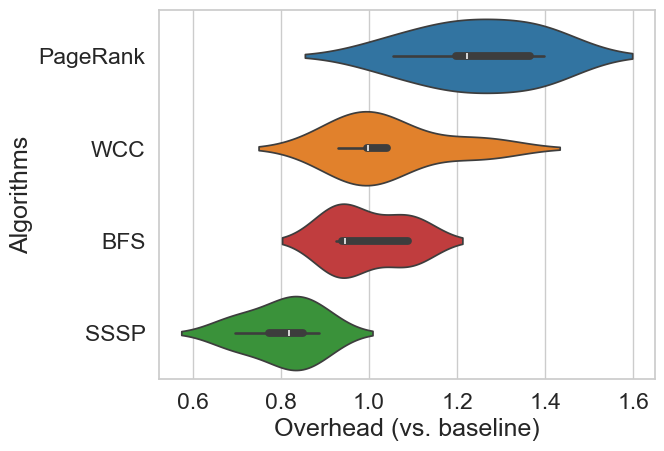

In [76]:
order = tracing_compare.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.violinplot(data=tracing_compare, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (vs. baseline)")
b.set_ylabel("Algorithms")
b.patch.set_alpha(0.)

plt.savefig(write_dir / "overhead.pdf", bbox_inches='tight')

# Provenance graph pruning (`joinVertices` op only)

In [163]:
data_dir = Path("das6") / "20240521-081524-provenancegraphpruning"
joinVertices = parse_experiment_output(root_dir / "data" / data_dir)
joinVertices.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration
8,provenancegraphpruning,BFS,cit-Patents,1,Text,False,2186387275,7,3774768,43,112.801936
11,provenancegraphpruning,BFS,datagen-7_5-fb,1,Text,False,189922202,7,633432,29,45.458680
2,provenancegraphpruning,BFS,datagen-7_9-fb,1,Text,False,435702119,7,1387587,31,92.726787
20,provenancegraphpruning,BFS,datagen-8_4-fb,1,Text,False,1527009988,7,3809084,35,270.010840
5,provenancegraphpruning,BFS,datagen-8_8-zf,1,Text,False,15081382026,7,168308893,21,321.979103
1,provenancegraphpruning,BFS,graph500-22,1,Text,False,0,7,2396657,3,34.608081
3,provenancegraphpruning,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,84.410510
13,provenancegraphpruning,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,42.430770
7,provenancegraphpruning,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,66.426430
18,provenancegraphpruning,PageRank,datagen-8_4-fb,1,Text,False,0,7,3809084,35,203.860126


In [164]:
joinVertices_compare_duration = merge_compare(storage_baseline, joinVertices, metric="duration")
# joinVertices_compare_duration = joinVertices_compare_duration[joinVertices_compare_duration["algorithm"] != "PageRank"]
#joinVertices_compare_duration = joinVertices_compare_duration[joinVertices_compare_duration["total_size"] != 0]
joinVertices_compare_duration.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_duration,overhead
6,provenancegraphpruning,BFS,cit-Patents,1,Text,False,2186387275,7,3774768,43,112.801936,101.973519,1.106189
7,provenancegraphpruning,BFS,datagen-7_5-fb,1,Text,False,189922202,7,633432,29,45.458680,41.142354,1.104912
2,provenancegraphpruning,BFS,datagen-7_9-fb,1,Text,False,435702119,7,1387587,31,92.726787,61.450592,1.508965
1,provenancegraphpruning,BFS,graph500-22,1,Text,False,0,7,2396657,3,34.608081,42.711168,0.810282
3,provenancegraphpruning,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,84.410510,142.736847,0.591372
9,provenancegraphpruning,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,42.430770,61.612538,0.688671
5,provenancegraphpruning,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,66.426430,115.157119,0.576833
8,provenancegraphpruning,SSSP,datagen-7_5-fb,1,Text,False,193732521,7,633432,30,45.962457,41.157125,1.116756
0,provenancegraphpruning,SSSP,datagen-7_9-fb,1,Text,False,467315962,7,1387587,32,77.736612,92.144127,0.843642
4,provenancegraphpruning,WCC,cit-Patents,1,Text,False,965132860,7,3774768,41,210.021617,190.549338,1.102190


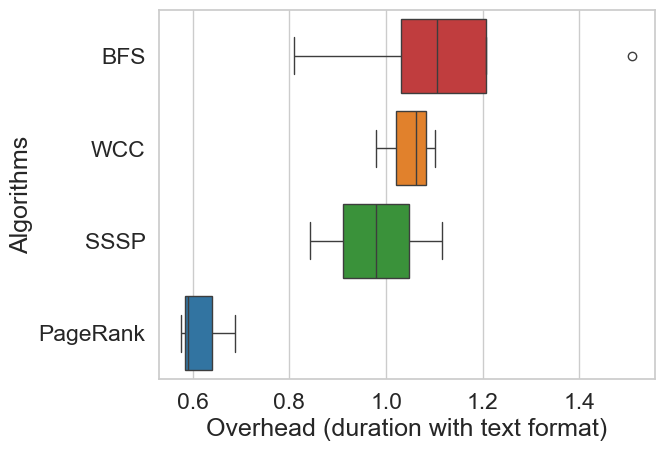

In [166]:
order = joinVertices_compare_duration.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=joinVertices_compare_duration, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (duration with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "overhead-duration.pdf", bbox_inches='tight')

In [167]:
joinVertices_compare_size = merge_compare(storage_baseline, joinVertices, metric="total_size")
# joinVertices_compare_size = joinVertices_compare_size[joinVertices_compare_size["algorithm"] != "PageRank"]
joinVertices_compare_size.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_total_size,overhead
6,provenancegraphpruning,BFS,cit-Patents,1,Text,False,2186387275,7,3774768,43,112.801936,2525597803,0.865691
7,provenancegraphpruning,BFS,datagen-7_5-fb,1,Text,False,189922202,7,633432,29,45.458680,256529225,0.740353
2,provenancegraphpruning,BFS,datagen-7_9-fb,1,Text,False,435702119,7,1387587,31,92.726787,581855399,0.748815
1,provenancegraphpruning,BFS,graph500-22,1,Text,False,0,7,2396657,3,34.608081,213794112,0.000000
3,provenancegraphpruning,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,84.410510,2834235312,0.000000
9,provenancegraphpruning,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,42.430770,552752499,0.000000
5,provenancegraphpruning,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,66.426430,1216101565,0.000000
8,provenancegraphpruning,SSSP,datagen-7_5-fb,1,Text,False,193732521,7,633432,30,45.962457,254670929,0.760717
0,provenancegraphpruning,SSSP,datagen-7_9-fb,1,Text,False,467315962,7,1387587,32,77.736612,601133226,0.777392
4,provenancegraphpruning,WCC,cit-Patents,1,Text,False,965132860,7,3774768,41,210.021617,1100333124,0.877128


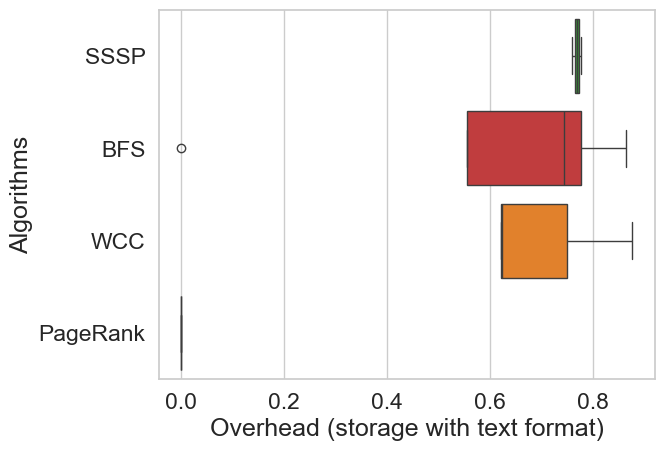

In [168]:
order = joinVertices_compare_size.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=joinVertices_compare_size, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (storage with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "overhead-size.pdf", bbox_inches='tight')

# Data graph pruning (delta comparison)

In [169]:
data_dir = Path("das6") / "20240521-093950-datagraphpruning"
smart_pruning = parse_experiment_output(root_dir / "data" / data_dir)
smart_pruning.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration
14,datagraphpruning,BFS,cit-Patents,1,Text,False,50535370,7,3774768,43,76.262150
2,datagraphpruning,BFS,datagen-7_5-fb,1,Text,False,99098478,7,633432,29,39.157005
15,datagraphpruning,BFS,datagen-7_9-fb,1,Text,False,242483171,7,1387587,31,59.394301
12,datagraphpruning,BFS,datagen-8_4-fb,1,Text,False,627415867,7,3809084,35,239.188734
17,datagraphpruning,BFS,datagen-8_8-zf,1,Text,False,158760,7,168308893,21,158.303025
8,datagraphpruning,BFS,graph500-22,1,Text,False,33,7,2396657,3,35.277343
3,datagraphpruning,PageRank,cit-Patents,1,Text,False,2795333038,7,3774768,35,189.454736
16,datagraphpruning,PageRank,datagen-7_5-fb,1,Text,False,550374485,7,633432,35,78.914126
13,datagraphpruning,PageRank,datagen-7_9-fb,1,Text,False,1210719851,7,1387587,35,128.222824
1,datagraphpruning,PageRank,datagen-8_4-fb,1,Text,False,3313983586,7,3809084,35,412.159718


In [170]:
smart_pruning_compare_duration = merge_compare(storage_baseline, smart_pruning, metric="duration")
smart_pruning_compare_duration.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_duration,overhead
6,datagraphpruning,BFS,cit-Patents,1,Text,False,50535370,7,3774768,43,76.262150,101.973519,0.747862
0,datagraphpruning,BFS,datagen-7_5-fb,1,Text,False,99098478,7,633432,29,39.157005,41.142354,0.951744
7,datagraphpruning,BFS,datagen-7_9-fb,1,Text,False,242483171,7,1387587,31,59.394301,61.450592,0.966537
3,datagraphpruning,BFS,graph500-22,1,Text,False,33,7,2396657,3,35.277343,42.711168,0.825951
1,datagraphpruning,PageRank,cit-Patents,1,Text,False,2795333038,7,3774768,35,189.454736,142.736847,1.327301
8,datagraphpruning,PageRank,datagen-7_5-fb,1,Text,False,550374485,7,633432,35,78.914126,61.612538,1.280813
5,datagraphpruning,PageRank,datagen-7_9-fb,1,Text,False,1210719851,7,1387587,35,128.222824,115.157119,1.113460
10,datagraphpruning,SSSP,datagen-7_5-fb,1,Text,False,133167600,7,633432,30,40.820508,41.157125,0.991821
9,datagraphpruning,SSSP,datagen-7_9-fb,1,Text,False,337239338,7,1387587,32,67.234251,92.144127,0.729664
2,datagraphpruning,WCC,cit-Patents,1,Text,False,1100333124,7,3774768,41,182.512176,190.549338,0.957821


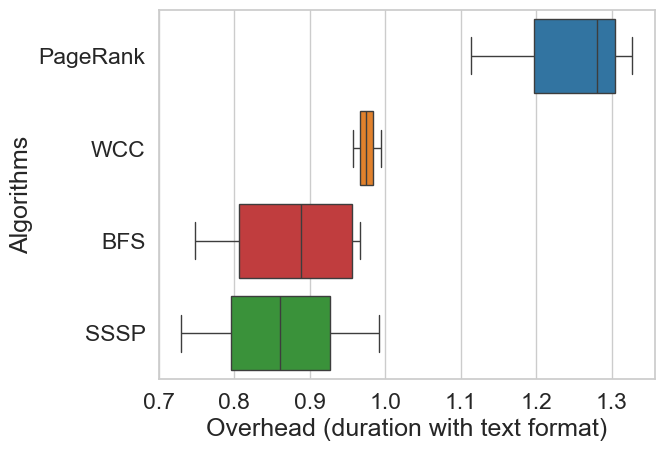

In [172]:
order = smart_pruning_compare_duration.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=smart_pruning_compare_duration, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (duration with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "overhead-duration.pdf", bbox_inches='tight')

In [173]:
smart_pruning_compare_size = merge_compare(storage_baseline, smart_pruning, metric="total_size")
smart_pruning_compare_size.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_total_size,overhead
6,datagraphpruning,BFS,cit-Patents,1,Text,False,50535370,7,3774768,43,76.262150,2525597803,2.000927e-02
0,datagraphpruning,BFS,datagen-7_5-fb,1,Text,False,99098478,7,633432,29,39.157005,256529225,3.863048e-01
7,datagraphpruning,BFS,datagen-7_9-fb,1,Text,False,242483171,7,1387587,31,59.394301,581855399,4.167413e-01
3,datagraphpruning,BFS,graph500-22,1,Text,False,33,7,2396657,3,35.277343,213794112,1.543541e-07
1,datagraphpruning,PageRank,cit-Patents,1,Text,False,2795333038,7,3774768,35,189.454736,2834235312,9.862742e-01
8,datagraphpruning,PageRank,datagen-7_5-fb,1,Text,False,550374485,7,633432,35,78.914126,552752499,9.956979e-01
5,datagraphpruning,PageRank,datagen-7_9-fb,1,Text,False,1210719851,7,1387587,35,128.222824,1216101565,9.955746e-01
10,datagraphpruning,SSSP,datagen-7_5-fb,1,Text,False,133167600,7,633432,30,40.820508,254670929,5.229007e-01
9,datagraphpruning,SSSP,datagen-7_9-fb,1,Text,False,337239338,7,1387587,32,67.234251,601133226,5.610060e-01
2,datagraphpruning,WCC,cit-Patents,1,Text,False,1100333124,7,3774768,41,182.512176,1100333124,1.000000e+00


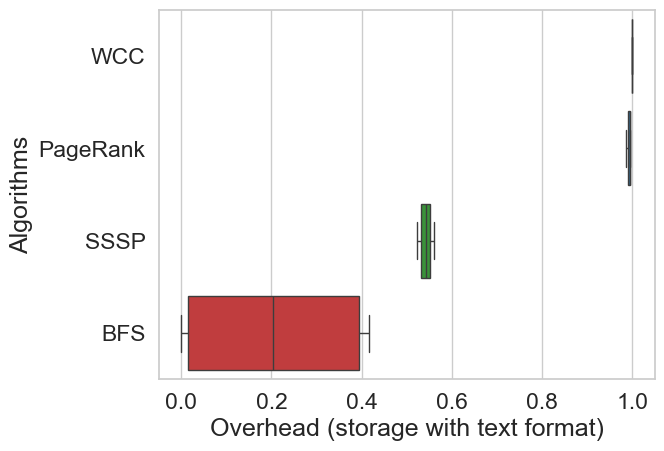

In [174]:
order = smart_pruning_compare_size.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=smart_pruning_compare_size, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (storage with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "overhead-size.pdf", bbox_inches='tight')

# Combined pruning

In [175]:
data_dir = Path("das6") / "20240521-111351-combinedpruning"
combined = parse_experiment_output(root_dir / "data" / data_dir)
combined.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration
6,combinedpruning,BFS,cit-Patents,1,Text,False,50535334,7,3774768,43,97.991459
2,combinedpruning,BFS,datagen-7_5-fb,1,Text,False,99098460,7,633432,29,40.551124
1,combinedpruning,BFS,datagen-7_9-fb,1,Text,False,242483153,7,1387587,31,110.392218
7,combinedpruning,BFS,datagen-8_4-fb,1,Text,False,627415849,7,3809084,35,265.831706
10,combinedpruning,BFS,datagen-8_8-zf,1,Text,False,158742,7,168308893,21,202.223527
8,combinedpruning,BFS,graph500-22,1,Text,False,0,7,2396657,3,28.202130
18,combinedpruning,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,89.170014
13,combinedpruning,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,35.329524
3,combinedpruning,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,67.376054
0,combinedpruning,PageRank,datagen-8_4-fb,1,Text,False,0,7,3809084,35,237.889833


In [176]:
combined_compare_duration = merge_compare(storage_baseline, combined, metric="duration")
combined_compare_duration.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_duration,overhead
4,combinedpruning,BFS,cit-Patents,1,Text,False,50535334,7,3774768,43,97.991459,101.973519,0.960950
1,combinedpruning,BFS,datagen-7_5-fb,1,Text,False,99098460,7,633432,29,40.551124,41.142354,0.985630
0,combinedpruning,BFS,datagen-7_9-fb,1,Text,False,242483153,7,1387587,31,110.392218,61.450592,1.796439
5,combinedpruning,BFS,graph500-22,1,Text,False,0,7,2396657,3,28.202130,42.711168,0.660299
10,combinedpruning,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,89.170014,142.736847,0.624716
8,combinedpruning,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,35.329524,61.612538,0.573415
2,combinedpruning,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,67.376054,115.157119,0.585079
3,combinedpruning,SSSP,datagen-7_5-fb,1,Text,False,133167568,7,633432,30,43.168527,41.157125,1.048871
9,combinedpruning,SSSP,datagen-7_9-fb,1,Text,False,337239306,7,1387587,32,102.904335,92.144127,1.116776
6,combinedpruning,WCC,cit-Patents,1,Text,False,965132860,7,3774768,41,187.507095,190.549338,0.984034


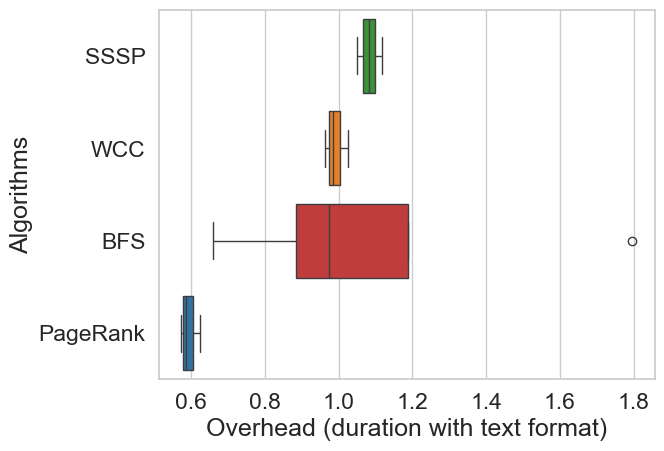

In [177]:
order = combined_compare_duration.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.boxplot(data=combined_compare_duration, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (duration with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "overhead-duration.pdf", bbox_inches='tight')

In [178]:
combined_compare_size = merge_compare(storage_baseline, combined[combined["total_size"] > 0], metric="total_size")
combined_compare_size.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_total_size,overhead
3,combinedpruning,BFS,cit-Patents,1,Text,False,50535334,7,3774768,43,97.991459,2525597803,0.020009
1,combinedpruning,BFS,datagen-7_5-fb,1,Text,False,99098460,7,633432,29,40.551124,256529225,0.386305
0,combinedpruning,BFS,datagen-7_9-fb,1,Text,False,242483153,7,1387587,31,110.392218,581855399,0.416741
2,combinedpruning,SSSP,datagen-7_5-fb,1,Text,False,133167568,7,633432,30,43.168527,254670929,0.522901
6,combinedpruning,SSSP,datagen-7_9-fb,1,Text,False,337239306,7,1387587,32,102.904335,601133226,0.561006
4,combinedpruning,WCC,cit-Patents,1,Text,False,965132860,7,3774768,41,187.507095,1100333124,0.877128
7,combinedpruning,WCC,datagen-7_5-fb,1,Text,False,58425032,7,633432,13,37.925038,94026180,0.621370
5,combinedpruning,WCC,datagen-7_9-fb,1,Text,False,129855334,7,1387587,13,76.020076,208169138,0.623797


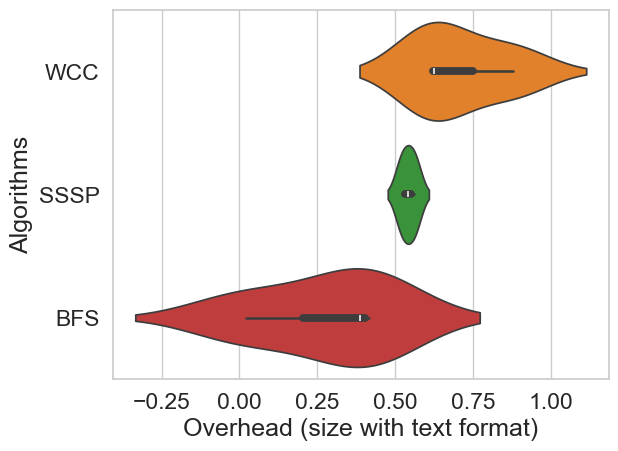

In [179]:
order = combined_compare_size.groupby(by=["algorithm"])["overhead"].median().sort_values(ascending=False).index
b = sns.violinplot(data=combined_compare_size, x="overhead", y="algorithm", hue="algorithm", palette=algorithm_colors, order=order)
b.set_xlabel("Overhead (size with text format)")
b.set_ylabel("Algorithms")
write_dir = (plot_dir / data_dir)
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "overhead-size.pdf", bbox_inches='tight')

In [180]:
gg_combined = node_sizes.rename(columns={"total_size": "baseline_graph_size"})
gg2_combined = pd.merge(combined, gg_combined, on=["dataset"])
gg2_combined["blowup"] = gg2_combined["total_size"] / gg2_combined["baseline_graph_size"]
gg2_combined.sort_values(by=["algorithm", "dataset", "storage_format"])

,config,algorithm,dataset,run,storage_format,compressed,total_size,nr_executors,nr_vertices,iterations,duration,baseline_graph_size,blowup
15,combinedpruning,BFS,cit-Patents,1,Text,False,50535334,7,3774768,43,97.991459,30025298,1.683092
8,combinedpruning,BFS,datagen-7_5-fb,1,Text,False,99098460,7,633432,29,40.551124,8266855,11.987444
4,combinedpruning,BFS,datagen-7_9-fb,1,Text,False,242483153,7,1387587,31,110.392218,18190864,13.329942
1,combinedpruning,BFS,datagen-8_4-fb,1,Text,False,627415849,7,3809084,35,265.831706,50232462,12.490247
13,combinedpruning,BFS,datagen-8_8-zf,1,Text,False,158742,7,168308893,21,202.223527,2267897486,0.000070
18,combinedpruning,BFS,graph500-22,1,Text,False,0,7,2396657,3,28.202130,18538268,0.000000
17,combinedpruning,PageRank,cit-Patents,1,Text,False,0,7,3774768,35,89.170014,30025298,0.000000
10,combinedpruning,PageRank,datagen-7_5-fb,1,Text,False,0,7,633432,35,35.329524,8266855,0.000000
5,combinedpruning,PageRank,datagen-7_9-fb,1,Text,False,0,7,1387587,35,67.376054,18190864,0.000000
0,combinedpruning,PageRank,datagen-8_4-fb,1,Text,False,0,7,3809084,35,237.889833,50232462,0.000000


In [181]:
#sns.boxplot(gg2_combined[gg2_combined["total_size"] > 1024**2], x="blowup")

In [182]:
storage_baseline["scenario"] = "Complete provenance"
joinVertices_compare_size["scenario"] = "Provenance pruning"
smart_pruning_compare_size["scenario"] = "Data pruning"
combined["scenario"] = "Combined pruning"
together = [
    storage_baseline,
    joinVertices_compare_size,
    smart_pruning_compare_size,
    combined
]
all_together = pd.concat(together)
awww = all_together[["scenario", "dataset", "total_size"]][all_together["total_size"] > 1024**2]
gg_combined = node_sizes.rename(columns={"total_size": "baseline_graph_size"})
gg2_combined = pd.merge(awww, gg_combined, on=["dataset"])
gg2_combined["blowup"] = gg2_combined["total_size"] / gg2_combined["baseline_graph_size"]
gg2_combined

/var/folders/4z/sr1jzyjd3sjfsw6tlm7k49180000gn/T/ipykernel_43690/4184565240.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  storage_baseline["scenario"] = "Complete provenance"


,scenario,dataset,total_size,baseline_graph_size,blowup
0,Complete provenance,datagen-7_9-fb,208169138,18190864,11.443609
1,Complete provenance,datagen-7_9-fb,581855399,18190864,31.986133
2,Complete provenance,datagen-7_9-fb,1216101565,18190864,66.852326
3,Complete provenance,datagen-7_9-fb,601133226,18190864,33.045886
4,Provenance pruning,datagen-7_9-fb,467315962,18190864,25.689597
5,Provenance pruning,datagen-7_9-fb,435702119,18190864,23.951700
6,Provenance pruning,datagen-7_9-fb,129855334,18190864,7.138492
7,Data pruning,datagen-7_9-fb,1210719851,18190864,66.556479
8,Data pruning,datagen-7_9-fb,242483171,18190864,13.329942
9,Data pruning,datagen-7_9-fb,337239338,18190864,18.538940


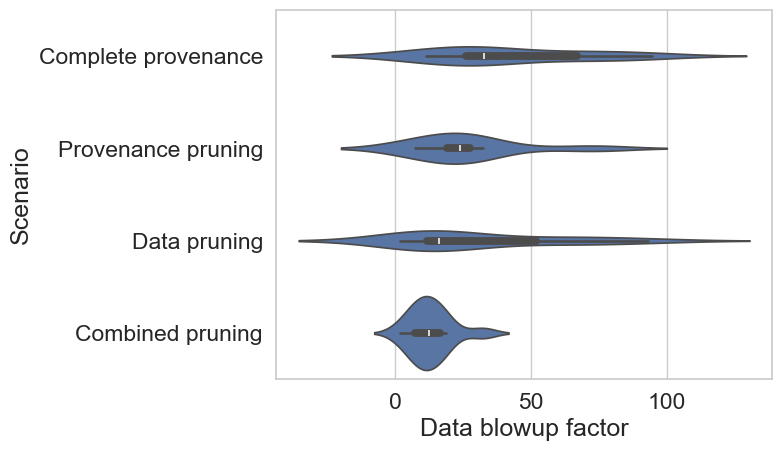

In [183]:
ax = sns.violinplot(gg2_combined, x="blowup", y="scenario")
ax.set_ylabel("Scenario")
ax.set_xlabel("Data blowup factor")
#plt.savefig("/Users/gm/Downloads/blowup.svg", bbox_inches='tight')
write_dir = (plot_dir / "das6" / "conclusion")
write_dir.mkdir(exist_ok=True, parents=True)
plt.savefig(write_dir / "factor.pdf", bbox_inches='tight')